# Tree pruning


Tree pruning, also known as tree pruning or post-pruning, is a technique used in decision tree construction to prevent overfitting and improve the generalization ability of the tree. Overfitting occurs when a decision tree becomes too complex and fits the training data too closely, capturing noise and leading to poor performance on unseen data. Pruning helps simplify the tree while retaining its essential structure.

1. <h4>Why Prune Trees:</h4>

* Decision trees can grow deep and become overly complex, especially when they capture noise in the training data.
* Deep trees are likely to overfit, meaning they perform well on the training data but poorly on unseen data.
* Pruning aims to reduce the depth of the tree and remove branches that do not contribute significantly to predictive accuracy.

2. <h4>Pruning Methods:</h4>

* <h6>Reduced Error Pruning:</h6>  In reduced error pruning, the tree is first built using the training data. Then, a portion of the training data is set aside as a validation dataset. Starting from the leaves, each node is replaced with its most common class label in the validation dataset. If this replacement results in improved accuracy on the validation data, the pruning is accepted.
<br>

* <h6>Cost-Complexity Pruning (Minimal Cost-Complexity Pruning): </h6> Cost-complexity pruning is a method that assigns a cost to each subtree based on its complexity and performance on the validation data. By selecting subtrees with lower costs, the tree can be pruned to an optimal level. This method uses a hyperparameter called the complexity parameter (often denoted as α) to control the trade-off between simplicity and accuracy.
<br>

3. <h6>Complexity Parameter (α):</h6>
* The complexity parameter (α) in cost-complexity pruning controls the level of pruning. Smaller values of α lead to more aggressive pruning and simpler trees, while larger values result in more complex trees.
* Cross-validation is often used to select an appropriate value of α that balances tree complexity and predictive accuracy.
<br>

4. <h6>Post-Pruning Process:</h6>
The post-pruning process involves evaluating the impact of removing a node or subtree from the tree on the validation data.
Pruning is typically performed from the bottom up, starting with the leaf nodes and working towards the root.
<br>

5. <h6>Pruned Tree:</h6>
* After pruning, the decision tree will have fewer nodes and a shallower depth.
* The pruned tree should have improved generalization performance compared to the unpruned tree.
<br>

6. <h6>Benefits of Pruning:</h6>
* Reduced overfitting: Pruning helps the decision tree generalize better to unseen data.
* Improved interpretability: A pruned tree is often simpler and easier to interpret.
* Reduced computational complexity: Simpler trees require fewer computational resources for prediction.
<br>

7. <h6>Trade-Offs:</h6>
* Pruning involves a trade-off between model simplicity and predictive accuracy. Over-pruning (too aggressive pruning) can lead to underfitting.

Tree pruning is an important technique in decision tree-based algorithms, such as CART (Classification and Regression Trees) and Random Forests. Properly pruned trees can strike a balance between model complexity and predictive accuracy, making them more robust and interpretable for various machine learning tasks.

##### Python implementation

### Post pruning decision trees with cost complexity pruning

The DecisionTreeClassifier provides parameters such as min_samples_leaf and max_depth to prevent a tree from overfiting. Cost complexity pruning provides another option to control the size of a tree. In DecisionTreeClassifier, this pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned. Here we only show the effect of ccp_alpha on regularizing the trees and how to choose a ccp_alpha based on validation scores.

See also Minimal Cost-Complexity Pruning for details on pruning.

In [1]:
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

### Total impurity of leaves vs effective alphas of pruned tree

Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides DecisionTreeClassifier.cost_complexity_pruning_path that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.



In [2]:
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

clf = DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

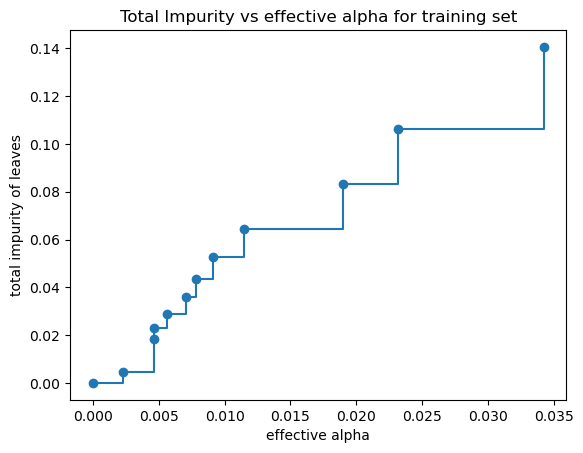

In [3]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [4]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.3272984419327777


For the remainder of this example, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

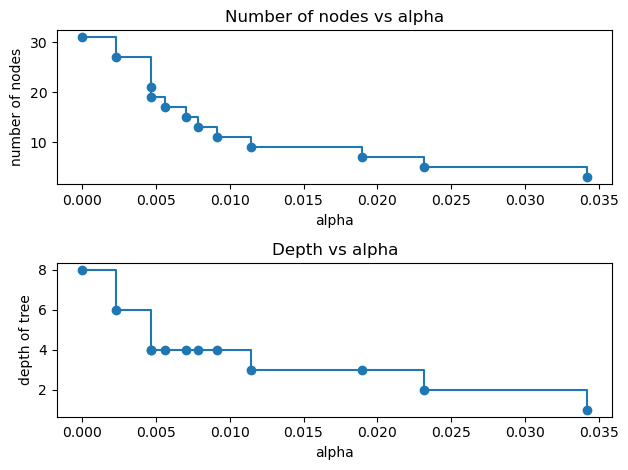

In [5]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

### Accuracy vs alpha for training and testing sets

When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. In this example, setting ccp_alpha=0.015 maximizes the testing accuracy.

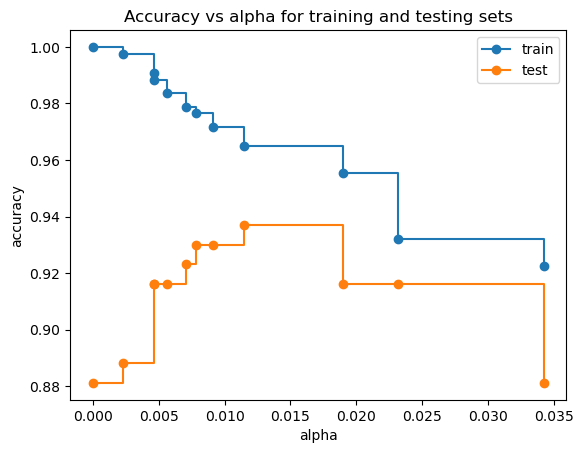

In [6]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()